# AE352 Project: Quadcopter 

## This file will walk through reproducing the results. 

Access the README document for details on different test cases.

Import modules.

In [17]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import secrets
import importlib
import simulator
importlib.reload(simulator)
import sympy as sym
from sympy import Matrix, diag, nsimplify, lambdify
import numpy as np
import scipy.signal
import scipy.linalg


# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

Create and print a seed for the random number generator so it is possible to reproduce the results. Not relevant for testing in this project, but needed for sim initialization 

In [3]:
seed = secrets.randbits(32)
print(seed)

1439958713


Create simulator with seed. Appears in most recently used web browser. Uses the simulator,py file to initialize the environment

In [5]:
simulator = simulator.Simulator(
    display=True,
    display_pybullet=False,
    seed=seed,
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


Mathematical foundation for drone dynamics, explained in report. Produces relevant matrices based on drone parameters that are used by the feedback loop controller. Also provides test methods to ensure functionality such as controlability.

In [6]:
class DroneDynamics:
    def __init__(self):
        """
        Initializes the Drone Dynamics class by defining symbolic variables for drone's position, orientation, 
        velocity, angular velocity, torques, and force. It also sets the drone's physical parameters, initializes 
        matrices, computes equations of motion, and calculates matrices A, B, C, D, K, and L required for control 
        and dynamics analysis.
        """
        # Define symbols
        self.p_x, self.p_y, self.p_z = sym.symbols('p_x, p_y, p_z')
        self.psi, self.theta, self.phi = sym.symbols('psi, theta, phi')
        self.v_x, self.v_y, self.v_z = sym.symbols('v_x, v_y, v_z')
        self.w_x, self.w_y, self.w_z = sym.symbols('w_x, w_y, w_z')
        self.tau_x, self.tau_y, self.tau_z = sym.symbols('tau_x, tau_y, tau_z')
        self.f_z = sym.symbols('f_z')

        # Define parameters
        self.params = {
            'm': 0.5,
            'Jx': 0.0023,
            'Jy': 0.0023,
            'Jz': 0.0040,
            'l': 0.175,
            'g': 9.81,
        }
        self.equilibrium_values = {
            'p_xe': 0, 'p_ye': 0, 'p_ze': 0,
            'psi_e': 0, 'theta_e': 0, 'phi_e': 0,
            'v_xe': 0, 'v_ye': 0, 'v_ze': 0,
            'w_xe': 0, 'w_ye': 0, 'w_ze': 0,
            'tau_xe': 0, 'tau_ye': 0, 'tau_ze': 0,
            'f_ze': 4.905  # 0.5 * 9.81
        }
        self._init_params()

        # Define other matrices and equations
        self._init_matrices()
        self._compute_equations()

        # Calculate A, B, C, D, K, L
        self._calculate_ABCD(self.equilibrium_values)
        self._calculate_KL()

    def _init_params(self):
        """
        Initializes the drone's physical parameters like mass, moments of inertia, arm length, and gravity. 
        These parameters are essential for the dynamics and control of the drone. The method also computes 
        an equilibrium force required to counteract gravity based on the drone's configuration.
        """
        self.m = nsimplify(self.params['m'])
        self.Jx = nsimplify(self.params['Jx'])
        self.Jy = nsimplify(self.params['Jy'])
        self.Jz = nsimplify(self.params['Jz'])
        self.l = nsimplify(self.params['l'])
        self.g = nsimplify(self.params['g'])
        self.J = diag(self.Jx, self.Jy, self.Jz)
        self.vxe = 1.0
        self.wye = 0.0
        self.vye = 1.0
        self.wxe = 0.0
        self.phie = 0.0
        self.thetae = 0.0
        self.fze = -(self.vxe * self.wye - self.vye*self.wxe - 981 * np.cos(self.phie) * np.cos(self.thetae) / 100) / 2

    def _init_matrices(self):
        """
        Initializes rotation matrices (Rz, Ry, Rx) representing the drone's orientation in 3D space. 
        """
        # rotation matrices
        self.Rz = Matrix([[sym.cos(self.psi), -sym.sin(self.psi), 0], 
                     [sym.sin(self.psi), sym.cos(self.psi), 0], 
                     [0, 0, 1]])
        self.Ry = Matrix([[sym.cos(self.theta), 0, sym.sin(self.theta)], 
                     [0, 1, 0], 
                     [-sym.sin(self.theta), 0, sym.cos(self.theta)]])
        self.Rx = Matrix([[1, 0, 0], 
                     [0, sym.cos(self.phi), -sym.sin(self.phi)], 
                     [0, sym.sin(self.phi), sym.cos(self.phi)]])
        self.R_body_in_world = self.Rz @ self.Ry @ self.Rx

    def _compute_equations(self):
        """
        Computes the equations of motion for the drone. This includes the calculation of linear and angular 
        velocities, transformation from angular velocity to angular rates, and the forces and torques acting 
        on the drone. The output is a symbolic representation of the drone's dynamics.
        """
        # components of linear velocity
        v_in_body = Matrix([self.v_x, self.v_y, self.v_z])

        # components of angular velocity
        w_in_body = Matrix([self.w_x, self.w_y, self.w_z])

        # angular velocity to angular rates
        ex = Matrix([[1], [0], [0]])
        ey = Matrix([[0], [1], [0]])
        ez = Matrix([[0], [0], [1]])
        M = sym.simplify(Matrix.hstack((self.Ry @ self.Rx).T @ ez, self.Rx.T @ ey, ex).inv(), full=True)

        # applied forces
        f_in_body = self.R_body_in_world.T @ Matrix([[0], [0], [-self.m * self.g]]) + Matrix([[0], [0], [self.f_z]])

        # applied torques
        tau_in_body = Matrix([[self.tau_x], [self.tau_y], [self.tau_z]])

        # equations of motion
        f = Matrix.vstack(
            self.R_body_in_world @ v_in_body,
            M @ w_in_body,
            (1 / self.m) * (f_in_body - w_in_body.cross(self.m * v_in_body)),
            self.J.inv() @ (tau_in_body - w_in_body.cross(self.J @ w_in_body)),
        )

        self.f = sym.simplify(f, full=True)

        # Sensor model
        p_in_world = Matrix([self.p_x, self.p_y, self.p_z])
        a_in_body = Matrix([self.l, 0, 0])  # marker on front rotor
        b_in_body = Matrix([-self.l, 0, 0]) # marker on rear rotor

        a_in_world = p_in_world + self.R_body_in_world @ a_in_body
        b_in_world = p_in_world + self.R_body_in_world @ b_in_body

        self.g = sym.simplify(Matrix.vstack(a_in_world, b_in_world))

    def _calculate_ABCD(self, equilibrium_values):
        """
        Calculates the linearized system matrices (A, B, C, D) around an equilibrium point. These matrices are 
        essential for control system design, such as in linear quadratic regulator (LQR) and observer design, 
        which rely on a linear approximation of the drone's dynamics.
        """
        p_xe, p_ye, p_ze, psi_e, theta_e, phi_e, v_xe, v_ye, v_ze, w_xe, w_ye, w_ze, tau_xe, tau_ye, tau_ze, f_ze = (
            equilibrium_values.get(k, 0) for k in [
                'p_xe', 'p_ye', 'p_ze', 'psi_e', 'theta_e', 'phi_e', 
                'v_xe', 'v_ye', 'v_ze', 'w_xe', 'w_ye', 'w_ze', 
                'tau_xe', 'tau_ye', 'tau_ze', 'f_ze'
            ]
        )

        self.A_num = sym.lambdify((self.p_x, self.p_y, self.p_z,
                            self.psi, self.theta, self.phi,
                            self.v_x, self.v_y, self.v_z,
                            self.w_x, self.w_y, self.w_z,
                            self.tau_x, self.tau_y, self.tau_z, self.f_z), 
                            self.f.jacobian([self.p_x, self.p_y, self.p_z, self.psi, self.theta, 
                                        self.phi, self.v_x, self.v_y, self.v_z, self.w_x, 
                                        self.w_y, self.w_z]))
        latex_matrix = sym.latex(self.f.jacobian([self.p_x, self.p_y, self.p_z, self.psi, self.theta, 
                                        self.phi, self.v_x, self.v_y, self.v_z, self.w_x, 
                                        self.w_y, self.w_z]))
        #print(latex_matrix)

        self.B_num =  sym.lambdify((self.p_x, self.p_y, self.p_z,
                            self.psi, self.theta, self.phi,
                            self.v_x, self.v_y, self.v_z,
                            self.w_x, self.w_y, self.w_z,
                            self.tau_x, self.tau_y, self.tau_z, self.f_z), 
                            self.f.jacobian([self.tau_x, self.tau_y, self.tau_z, self.f_z]))
        latex_matrix = sym.latex(self.f.jacobian([self.tau_x, self.tau_y, self.tau_z, self.f_z]))
        #print(latex_matrix)

        self.A = self.A_num(p_xe, p_ye, p_ze, psi_e, theta_e, phi_e, v_xe, v_ye, v_ze, w_xe, w_ye, w_ze, tau_xe, tau_ye, tau_ze, f_ze)
        self.B = self.B_num(p_xe, p_ye, p_ze, psi_e, theta_e, phi_e, v_xe, v_ye, v_ze, w_xe, w_ye, w_ze, tau_xe, tau_ye, tau_ze, f_ze)


        # Jacobian matrices C and D
        self.C_num = sym.lambdify((self.p_x, self.p_y, self.p_z, self.psi, self.theta), 
            self.g.jacobian([self.p_x, self.p_y, self.p_z, self.psi, self.theta, self.phi, 
            self.v_x, self.v_y, self.v_z, self.w_x, self.w_y, self.w_z]))
        latex_matrix = sym.latex(self.g.jacobian([self.p_x, self.p_y, self.p_z, self.psi, self.theta, self.phi, 
            self.v_x, self.v_y, self.v_z, self.w_x, self.w_y, self.w_z]))
        #print(latex_matrix)
        self.D_num = sym.lambdify((self.p_x, self.p_y, self.p_z, self.psi, self.theta), 
            self.g.jacobian([self.tau_x, self.tau_y, self.tau_z, self.f_z]))
        latex_matrix = sym.latex(self.g.jacobian([self.tau_x, self.tau_y, self.tau_z, self.f_z]))
        #print(latex_matrix)

        self.C = self.C_num(p_xe, p_ye, p_ze, psi_e, theta_e)
        self.D = self.D_num(p_xe, p_ye, p_ze, psi_e, theta_e)

    def _lqr(self, A, B, Q, R):
        """
        Solves the continuous-time linear quadratic regulator (LQR) problem. The LQR controller is designed to 
        minimize a cost function that balances the state error and control effort. The function returns the 
        optimal gain matrix K, which is used to control the system.

        :param A: System matrix.
        :param B: Input matrix.
        :param Q: State cost matrix.
        :param R: Control cost matrix.
        :return: Optimal gain matrix K.
        """
        P = scipy.linalg.solve_continuous_are(A, B, Q, R)
        K = np.linalg.inv(R) @ B.T @ P
        return K
    
    def _calculate_KL(self):
        """
        Calculates the feedback gain matrix K and the observer gain matrix L. K is calculated using pole placement 
        to ensure desired closed-loop behavior. L is calculated using the LQR approach for the dual system 
        (transposed system matrices) to design an observer that estimates the system states from outputs.
        """
        pole = np.linspace(-1, -5, 12)
        K = scipy.signal.place_poles(self.A,self.B, pole).gain_matrix

        Qo = np.identity(self.C.shape[0])
        Ro = np.identity(self.A.shape[0])

        Qinv = np.linalg.inv(Qo)
        Rinv = np.linalg.inv(Ro)

        L = self._lqr(self.A.T, self.C.T, Rinv, Qinv).T

        self.K = K
        self.L = L

    def test_stable_K(self):
        """
        Tests the stability of the feedback gain matrix K. Stability is ensured if the real parts of all 
        eigenvalues of (A - B*K) are negative. This method prints a statement regarding the stability of K.
        """
        eigens_K = np.linalg.eigvals(self.A - self.B @ self.K) 
        if np.all(np.real(eigens_K) < 0):
            print('K matrix is stable')

    def test_stable_L(self):
        """
        Tests the stability of the observer gain matrix L. Stability is ensured if the real parts of all 
        eigenvalues of (A.T - C.T*L.T) are negative. This method prints a statement regarding the stability of L.
        """
        eigens_L = np.linalg.eigvals(self.A.T - self.C.T @ self.L.T)
        if np.all(np.real(eigens_L) < 0):
            print('L matrix is stable')
    def check_controllability(self):
        """
        Checks if the system is controllable.
        """
        n = self.A.shape[0]  # number of states
        controllability_matrix = self.B
        self.W =controllability_matrix
        for i in range(1, n):
            controllability_matrix = np.hstack((controllability_matrix, np.linalg.matrix_power(self.A, i) @ self.B))

        if np.linalg.matrix_rank(controllability_matrix) == n:
            return True
        else:
            return False
    def check_observability(self):
        """
        Checks if the system is observable.
        """
        n = self.A.shape[0]  # number of states
        observability_matrix = self.C
        self.O = observability_matrix
        for i in range(1, n):
            observability_matrix = np.vstack((observability_matrix, self.C @ np.linalg.matrix_power(self.A, i)))

        if np.linalg.matrix_rank(observability_matrix) == n:
            return True
        else:
            return False



Test functionality. 

In [7]:
drone = DroneDynamics()
drone.test_stable_K()
drone.test_stable_L()
M=drone.L
# Check for controllability
if drone.check_controllability():
    print("The system is controllable.")
else:
    print("The system is not controllable.")

# Check for observability
if drone.check_observability():
    print("The system is observable.")
else:
    print("The system is not observable.")

The system is controllable.
The system is observable.


## Run Simulation 

Generate controller. Needs to be changed dependent on test cases. 

In [8]:
class Controller:
    def __init__(self):
        """
        List all class variables you want the simulator to log. For
        example, if you want the simulator to log "self.xhat", then
        do this:
        
            self.variables_to_log = ['xhat']
        
        Similarly, if you want the simulator to log "self.xhat" and
        "self.y", then do this:
        
            self.variables_to_log = ['xhat', 'y']
        
        Etc. These variables have to exist in order to be logged.
        """
        
        self.variables_to_log = ['xhat','x_des', 'v_des', 'rpm1', 'rpm2', 'rpm3', 'rpm4']
        self.dt  = .04
        self.A = drone.A
        self.B = drone.B
        self.C = drone.C
        self.D = drone.D
        self.K = drone.K
        self.L = drone.L
        self.fze = drone.fze
        self.base_rpm = 5000 
        self.hover_start_time = 0  # Time when hover started
        self.is_hovering = False   # Flag to indicate if currently hovering
        self.yaw_target = np.pi / 2
        self.current_checkpoint = 0


    def get_color(self):
        """
        If desired, change these three numbers - RGB values between
        0 and 1 - to change the color of your drone.
        """
        return [
            0., # <-- how much red (between 0 and 1)
            1., # <-- how much green (between 0 and 1)
            0., # <-- how much blue (between 0 and 1)
        ]

    def reset(
            self,
            p_x, p_y, p_z, # <-- approximate initial position of drone (meters)
            yaw,           # <-- approximate initial yaw angle of drone (radians)
        ):
        self.xhat = np.array([p_x,p_y,p_z,yaw,0,0,0,0,0,0,0,0]).astype(float)
        self.x_des = np.zeros(12)
    
    def compute_motor_rpms(self, F, tau_x, tau_y, tau_z):
        delta_thrust = F / 4
        delta_pitch = tau_y / 0.02
        delta_roll = tau_x / 0.02
        delta_yaw = tau_z / 0.04

        rpm1 = self.base_rpm + delta_thrust - delta_pitch + delta_roll - delta_yaw
        rpm2 = self.base_rpm + delta_thrust + delta_pitch + delta_roll + delta_yaw
        rpm3 = self.base_rpm + delta_thrust + delta_pitch - delta_roll - delta_yaw
        rpm4 = self.base_rpm + delta_thrust - delta_pitch - delta_roll + delta_yaw

        return rpm1, rpm2, rpm3, rpm4

    def run(
            self,
            pos_markers,
            pos_ring,
            dir_ring,
            is_last_ring,                 # <-- True if next ring is the last ring, False otherwise
            pos_others,                   # <-- 2d array of size n x 3, where n is the number
            time,                         #     of all *other* drones - the ith row in this array
                                          #     has the coordinates [x_i, y_i, z_i], in meters, of
                                          #     the ith other drone
                                          
        ):
        """
        pos_markers is a 1d array of length 6:
        
            [
                measured x position of marker on front rotor (meters),
                measured y position of marker on front rotor (meters),
                measured z position of marker on front rotor (meters),
                measured x position of marker on back rotor (meters),
                measured y position of marker on back rotor (meters),
                measured z position of marker on back rotor (meters),
            ]
        
        pos_ring is a 1d array of length 3:
        
            [
                x position of next ring center (meters),
                y position of next ring center (meters),
                z position of next ring center (meters),
            ]
        
        dir_ring is a 1d array of length 3:
        
            [
                x component of vector normal to next ring (meters),
                y component of vector normal to next ring (meters),
                z component of vector normal to next ring (meters),
            ]
        
        is_last_ring is a boolean that is True if the next ring is the
                     last ring, and False otherwise
        
        pos_others is a 2d array of size n x 3, where n is the number of
                   all *other* drones:
            
            [
                [x_1, y_1, z_1], # <-- position of 1st drone (meters)
                [x_2, y_2, z_2], # <-- position of 2nd drone (meters)
                
                ...
                
                [x_n, y_n, z_n], # <-- position of nth drone (meters)
            ]      
        """
        p_des = pos_ring
        v_des = np.zeros(3)
        
        # Checkpoints and landing point
        checkpoint1 = np.array([5, 0, 1])
        checkpoint2 = np.array([5, 5, 1])
        landing_point = np.array([5, 5, 0])  # target z is 0 for landing

        pos_est = self.xhat[0:3]
        distance_to_checkpoint1 = np.linalg.norm(checkpoint1 - pos_est)
        distance_to_checkpoint2 = np.linalg.norm(checkpoint2 - pos_est)
        distance_to_ground = pos_est[2]  # z-coordinate for height above ground

        # Handling hovering and landing
        if distance_to_checkpoint1 < 0.1 and not self.is_hovering:
            self.is_hovering = True
            self.current_checkpoint = 1

        if distance_to_checkpoint2 < 0.1 and not self.is_hovering:
            self.is_hovering = True
            self.current_checkpoint = 2

        if self.is_hovering:
            if self.current_checkpoint == 1:
                if time <= 11:
                    p_des = checkpoint1
                    v_des = np.zeros(3)
                else:
                    self.is_hovering = False
                    self.x_des[3] += np.pi / 2  # Yaw change after first hover
            elif self.current_checkpoint == 2:
                if time <= 26:
                    p_des = checkpoint2
                    v_des = np.zeros(3)
                else:
                    self.is_hovering = False
        else:
            
            # Normal flight control
            direction_to_target = pos_ring - pos_est
            unit_direction_to_target = direction_to_target / np.linalg.norm(direction_to_target)
            desired_speed = 0.5 if self.current_checkpoint == 1 else 1.0
            v_des = unit_direction_to_target * desired_speed
            p_des = pos_est + direction_to_target * 0.95 if np.linalg.norm(direction_to_target) > 0.95 else pos_ring
        
        # Landing phase after checkpoint 2 hover
        if time > 26 and distance_to_ground >= 0:
            p_des = landing_point
            v_des = np.array([0, 0, 0.01])  # descending slowly
            if distance_to_ground <= 0.02:
                v_des = np.zeros(3)

        # Control updates
        x_des = np.zeros(12)
        x_des[0:3] = p_des
        x_des[6:9] = v_des
        self.x_des = x_des
        self.v_des = v_des

        y = pos_markers
        u = -self.K @ (self.xhat - self.x_des)
        self.xhat += self.dt * (self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y))

        tau_x = u[0]
        tau_y = u[1]
        tau_z = u[2]
        if time > 26:
            f_z = 1
        else:
            f_z = u[3] + self.fze
        f_z = u[3] + self.fze
        # Motor RPM calculation
        self.rpm1, self.rpm2, self.rpm3, self.rpm4 = self.compute_motor_rpms(f_z, tau_x, tau_y, tau_z)

        return tau_x, tau_y, tau_z, f_z

Clear all drones.

In [9]:
simulator.clear_drones()


Define a controller for the drone.

Add the drone to the simulator. There are three arguments:

* `Controller` is the class definition
* `'template'` is the name of the drone
* `'helicarrier.png'` is the name of an image to use as a label


In [10]:
simulator.add_drone(Controller, 'template', 'helicarrier.png')

Adjust camera to track drone.

In [11]:
simulator.camera_droneview('template')

Reset the drone by setting initial conditions. Is changed depending on test case.

In [12]:
# simulator.reset()
simulator.reset(
    initial_conditions={
        'template': {
            'p_x': 0.,
            'p_y': 0.,
            'p_z': 0.,
            'yaw': 0.,
            'pitch': 0.,
            'roll': 0.,
            'v_x': 0.,
            'v_y': 0.,
            'v_z': 0.,
            'w_x': 0.,
            'w_y': 0.,
            'w_z': 0.,
            'p_x_meas': 0.0000000000000001,
            'p_y_meas': 0.0000000000000001,
            'p_z_meas': 0.0000000000000001,
            'yaw_meas': 0.0000000000000001,

        },
    },
)

Run simulation until `max_time` is reached or if the drone has been disqualified.

In [13]:
simulator.run(
    max_time=35.,       # <-- if None, then simulation will run until all drones fail or finish
    print_debug=True,  # <-- if False, then nothing will be printed (good for data collection)
)

Simulated 876 time steps in 35.0413 seconds (24.9991 time steps per second)


## Plotting the Results

Assuming,

* Added a drone with the name `template` to the simulator
* Ran the simulation

Get data.

In [14]:
data = simulator.get_data('template')

Plot trajectory.

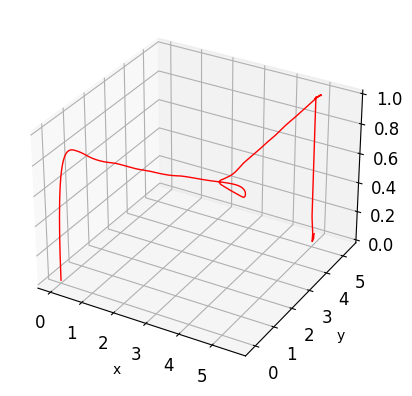

In [15]:
fig = plt.figure
ax = plt.axes(projection='3d')

ax.plot3D(data['p_x'], data['p_y'], data['p_z'], linewidth=1, color='red')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.grid()
ax.tick_params(labelsize=12)

Plot data.

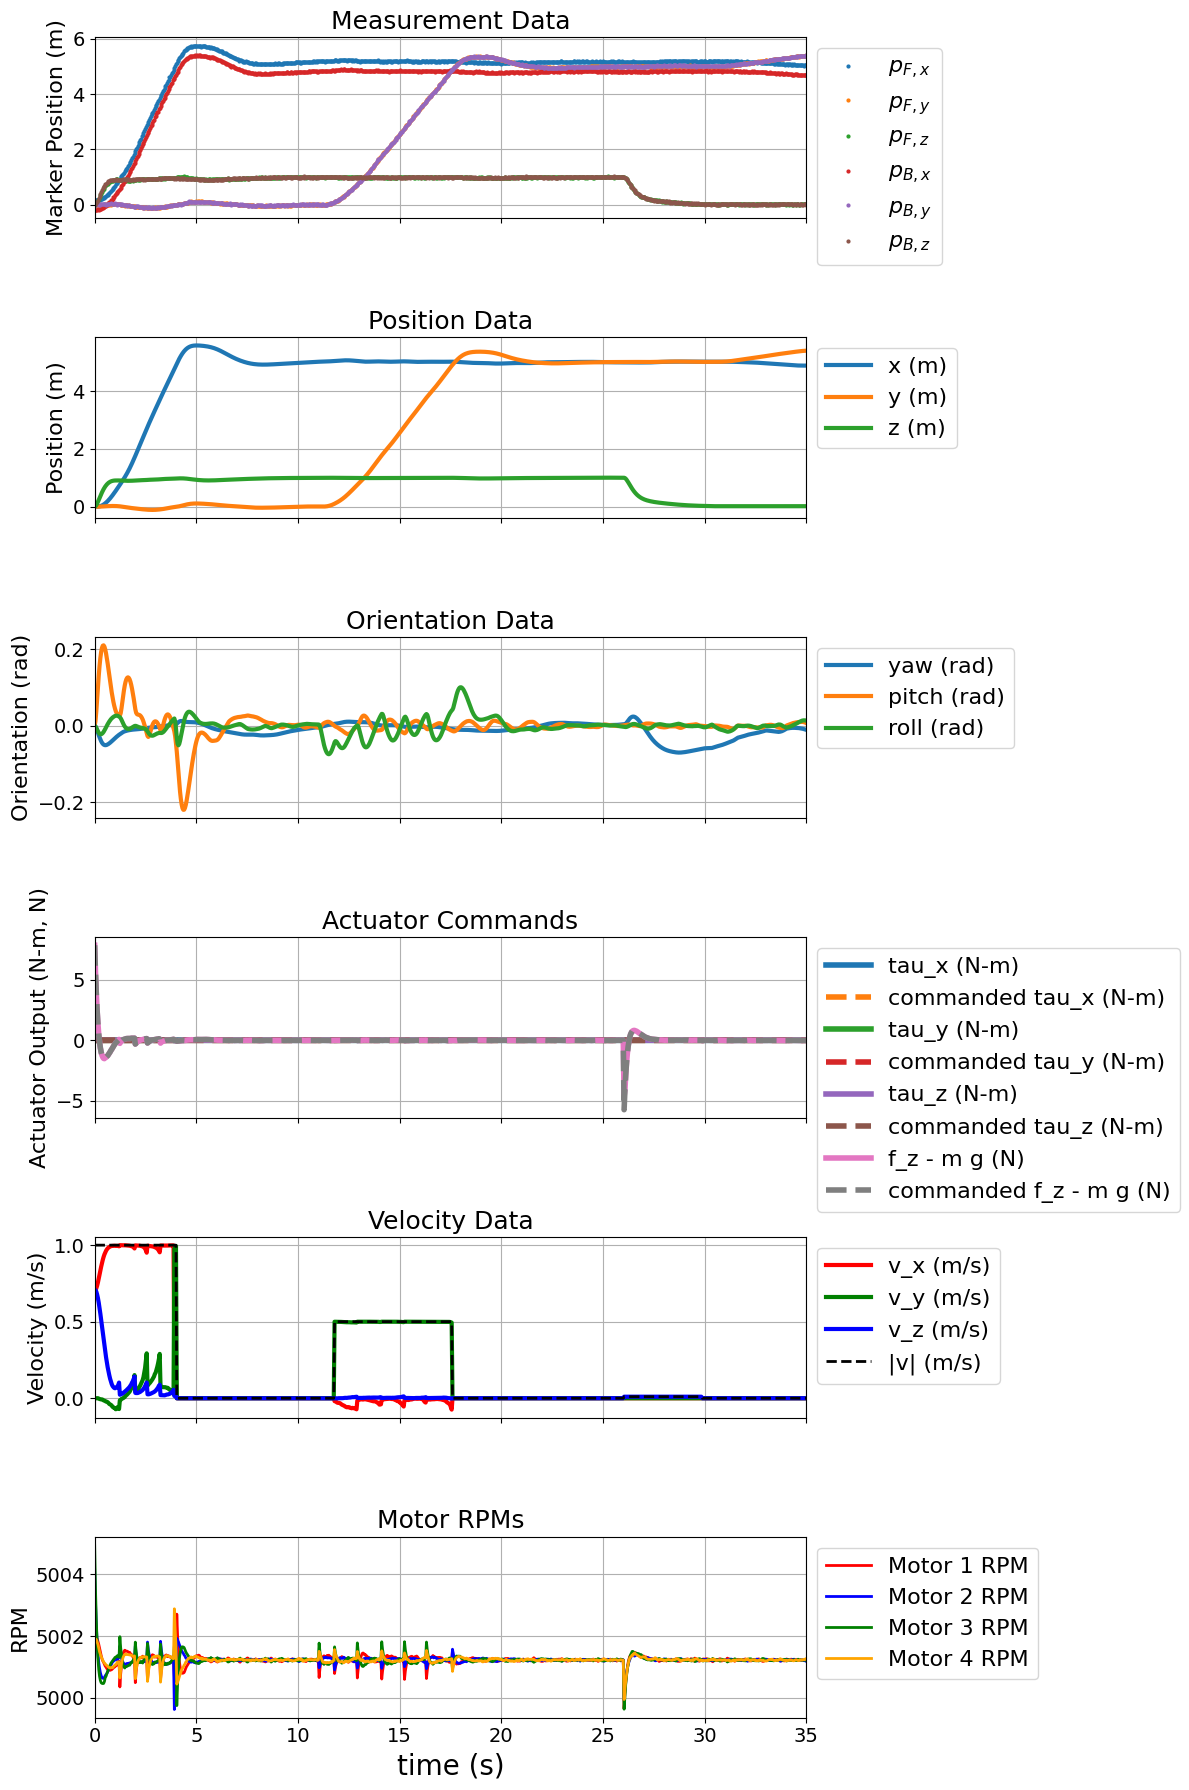

In [16]:
# Create a figure with subplots that all share the same x-axis
fig, (ax_meas, ax_pos, ax_ori, ax_act, ax_vel, ax_rpm) = plt.subplots(6, 1, figsize=(12, 18), sharex=True)

# Measurements
ax_meas.plot(data['t'], data['pos_markers'][:, 0], '.', markersize=4, label=r'$p_{F, x}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 1], '.', markersize=4, label=r'$p_{F, y}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 2], '.', markersize=4, label=r'$p_{F, z}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 3], '.', markersize=4, label=r'$p_{B, x}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 4], '.', markersize=4, label=r'$p_{B, y}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 5], '.', markersize=4, label=r'$p_{B, z}$')
ax_meas.grid()
ax_meas.legend(loc='upper left', fontsize=16, bbox_to_anchor=(1., 1.))
ax_meas.tick_params(labelsize=14)
ax_meas.set_ylabel('Marker Position (m)', fontsize=16)
ax_meas.set_title('Measurement Data', fontsize=18)


# Position
ax_pos.plot(data['t'], data['p_x'], label='x (m)', linewidth=3, color='C0')
ax_pos.plot(data['t'], data['p_y'], label='y (m)', linewidth=3, color='C1')
ax_pos.plot(data['t'], data['p_z'], label='z (m)', linewidth=3, color='C2')
ax_pos.grid()
ax_pos.legend(loc='upper left', fontsize=16, bbox_to_anchor=(1., 1.))
ax_pos.tick_params(labelsize=14)
ax_pos.set_ylabel('Position (m)', fontsize=16)
ax_pos.set_title('Position Data', fontsize=18)


# Velocity
ax_vel.plot(data['t'], data['v_des'][:, 0], label='v_x (m/s)', color='red', linewidth=3)
ax_vel.plot(data['t'], data['v_des'][:, 1], label='v_y (m/s)', color='green', linewidth=3)
ax_vel.plot(data['t'], data['v_des'][:, 2], label='v_z (m/s)', color='blue', linewidth=3)
velocity_magnitude = np.sqrt(np.sum(data['v_des']**2, axis=1)) # Calculate the magnitude of the velocity vector
ax_vel.plot(data['t'], velocity_magnitude, label='|v| (m/s)', color='black', linewidth=2, linestyle='--') # Plot the magnitude of the velocity
ax_vel.set_ylabel('Velocity (m/s)', fontsize=16)
ax_vel.grid(True)
ax_vel.legend(loc='upper left', fontsize=16, bbox_to_anchor=(1., 1.))
ax_vel.tick_params(labelsize=14)
ax_vel.set_title('Velocity Data', fontsize=18)



# Orientation
ax_ori.plot(data['t'], data['yaw'], label='yaw (rad)', linewidth=3)
ax_ori.plot(data['t'], data['pitch'], label='pitch (rad)', linewidth=3)
ax_ori.plot(data['t'], data['roll'], label='roll (rad)', linewidth=3)
ax_ori.grid()
ax_ori.legend(loc='upper left', fontsize=16, bbox_to_anchor=(1., 1.))
ax_ori.tick_params(labelsize=14)
ax_ori.set_ylabel('Orientation (rad)', fontsize=16)
ax_ori.set_title('Orientation Data', fontsize=18)


# Actuator commands
ax_act.plot(data['t'], data['tau_x'], label='tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_x_cmd'], '--', label='commanded tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y'], label='tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y_cmd'], '--', label='commanded tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z'], label='tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z_cmd'], '--', label='commanded tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['f_z'] - (0.5 * 9.81), label='f_z - m g (N)', linewidth=4) # <-- FIXME
ax_act.plot(data['t'], data['f_z_cmd'] - (0.5 * 9.81), '--', label='commanded f_z - m g (N)', linewidth=4) # <-- FIXME
ax_act.grid()
ax_act.legend(loc='upper left', fontsize=16, bbox_to_anchor=(1., 1.))
ax_act.tick_params(labelsize=14)
ax_act.set_ylabel('Actuator Output (N-m, N)', fontsize=16)
ax_act.set_title('Actuator Commands', fontsize=18)

# RPM for each motor
ax_rpm.plot(data['t'], data['rpm1'], label='Motor 1 RPM', color='red', linewidth=2)
ax_rpm.plot(data['t'], data['rpm2'], label='Motor 2 RPM', color='blue', linewidth=2)
ax_rpm.plot(data['t'], data['rpm3'], label='Motor 3 RPM', color='green', linewidth=2)
ax_rpm.plot(data['t'], data['rpm4'], label='Motor 4 RPM', color='orange', linewidth=2)
ax_rpm.set_ylabel('RPM', fontsize=16)
ax_rpm.set_title('Motor RPMs', fontsize=18)
ax_rpm.grid(True)
ax_rpm.legend(loc='upper left', fontsize=16, bbox_to_anchor=(1., 1.))
ax_rpm.tick_params(labelsize=14)



# Set shared x-axis properties
ax_rpm.set_xlabel('time (s)', fontsize=20)
ax_rpm.set_xlim([data['t'][0], data['t'][-1]])


# Make the arrangement of subplots look nice
fig.tight_layout()
plt.show()